In [1]:
import numpy as np
import jax.numpy as jnp
import jax

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
BLD = "../../../bld"

seed = 2024

n_choices = 12
n_agents = 10_000

In [3]:
MIN_AGE = 50
MAX_AGE = 65

AGE_50 = 50
AGE_53 = 53
AGE_56 = 56
AGE_59 = 59
AGE_62 = 62

AGE_55 = 55
AGE_60 = 60
AGE_65 = 65

GOOD_HEALTH = 0
MEDIUM_HEALTH = 1
BAD_HEALTH = 2

In [4]:
AGE_BINS = [(AGE_50, AGE_55), (AGE_55, AGE_60), (AGE_60, AGE_65)]
AGE_BINS_FINE = [
    (AGE_50, AGE_53),
    (AGE_53, AGE_56),
    (AGE_56, AGE_59),
    (AGE_59, AGE_62),
    (AGE_62, AGE_65),
]

In [5]:
ALL = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

NO_WORK = [0, 1, 2, 3]
PART_TIME = [4, 5, 6, 7]
FULL_TIME = [8, 9, 10, 11]
WORK = PART_TIME + FULL_TIME


NO_CARE = [0, 4, 8]
FORMAL_CARE = [1, 3, 5, 7, 9, 11]  # % 2 == 1
INFORMAL_CARE = [2, 3, 6, 7, 10, 11]
ANY_CARE = FORMAL_CARE + INFORMAL_CARE
COMBINATION_CARE = [3, 7, 11]

# NO_INFORMAL_CARE = [0, 1, 4, 5, 8, 9] # check!
# NO_FORMAL_CARE = [0, 2, 4, 6, 8, 10]
NO_INFORMAL_CARE = list(set(ANY_CARE) - (set(INFORMAL_CARE)))
NO_FORMAL_CARE =list(set(ALL) - (set(FORMAL_CARE)))

In [6]:
def is_not_working(lagged_choice):
    return lagged_choice in NO_WORK


def is_part_time(lagged_choice):
    return lagged_choice in PART_TIME


def is_full_time(lagged_choice):
    return lagged_choice in FULL_TIME


def is_informal_care(lagged_choice):
    # intensive only here
    return lagged_choice in INFORMAL_CARE


def is_no_informal_care(lagged_choice):
    # intensive only here
    return lagged_choice not in INFORMAL_CARE


def is_formal_care(lagged_choice):
    return lagged_choice in FORMAL_CARE


def is_no_formal_care(lagged_choice):
    return lagged_choice not in FORMAL_CARE

In [7]:
is_no_formal_care(0)

True

# 0. Draw Initial conditions

In [8]:
def _plot_dist(sample):
    sns.histplot(sample, bins=40, kde=True, color="purple")
    # plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.title("Distribution")
    plt.show()

In [9]:
path = f"{BLD}/moments/initial_wealth_at_age_50.csv"
initial_wealth_empirical = jnp.asarray(pd.read_csv(path)).ravel()

In [10]:
path = f"{BLD}/moments/initial_discrete_conditions_at_age_50.csv"
initial_conditions = pd.read_csv(path, index_col=0)

In [11]:
initial_conditions

moment
share_has_sister       0.537708
share_has_sibling      0.744326
share_married          0.719753
share_not_working      0.278238
share_part_time        0.350928
share_full_time        0.370834
share_informal_care    0.040574
mother_age_mean       76.367568
mother_age_std         4.199512
father_age_mean       77.471698
father_age_std         4.110863
share_mother_alive     0.652668
share_father_alive     0.308920
mother_good_health     0.209031
mother_medium_health   0.634474
mother_bad_health      0.156494
father_good_health     0.201967
father_medium_health   0.691185
father_bad_health      0.106848

In [12]:
# choices
employment = get_initial_share_three(
    initial_conditions, ["share_not_working", "share_part_time", "share_full_time"]
)
# informal_care = get_initial_share_two(initial_conditions, "share_informal_care")
informal_care = jnp.array([1, 0]) # agents start with no informal care provided
formal_care = jnp.array([1, 0]) # agents start with no formal care provided

informal_formal = jnp.outer(informal_care, formal_care)
lagged_choice_probs = jnp.outer(employment, informal_formal).flatten()

In [18]:
# endogenous states
married = get_initial_share_two(initial_conditions, "share_married")
has_sibling = get_initial_share_two(initial_conditions, "share_has_sibling")

# exogenous states
mother_alive = get_initial_share_two(initial_conditions, "share_mother_alive")
father_alive = get_initial_share_two(initial_conditions, "share_father_alive")

mother_health = get_initial_share_three(
    initial_conditions,
    ["mother_good_health", "mother_medium_health", "mother_bad_health"],
)
father_health = get_initial_share_three(
    initial_conditions,
    ["father_good_health", "father_medium_health", "father_bad_health"],
)

### Draw random

In [19]:
initial_resources = draw_random_sequence_from_array(
    seed, initial_wealth_empirical, n_agents=n_agents
)

In [20]:
initial_states = {
    "period": np.zeros(n_agents, dtype=np.int16),
    "lagged_choice": draw_random_array(
        seed=seed + 1,
        n_agents=n_agents,
        values=jnp.arange(n_choices),
        probabilities=lagged_choice_probs,
    ),
    "married": draw_random_array(
        seed=seed + 2,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=married,
    ),
    "has_sibling": draw_random_array(
        seed=seed + 3,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=has_sibling,
    ),
    "mother_age": draw_parental_age(
        seed=seed + 4,
        n_agents=n_agents,
        mean=jnp.asarray(initial_conditions.loc["mother_age_mean"]),
        std_dev=jnp.asarray(initial_conditions.loc["mother_age_std"]),
    ),
    "father_age": draw_parental_age(
        seed=seed + 5,
        n_agents=n_agents,
        mean=jnp.asarray(initial_conditions.loc["father_age_mean"]),
        std_dev=jnp.asarray(initial_conditions.loc["father_age_std"]),
    ),
    # exogenous states
    "mother_alive": draw_random_array(
        seed=seed + 6,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=mother_alive,
    ),
    "father_alive": draw_random_array(
        seed=seed + 7,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=father_alive,
    ),
    "mother_health": draw_random_array(
        seed=seed + 8,
        n_agents=n_agents,
        values=jnp.array([0, 1, 2]),
        probabilities=mother_health,
    ),
    "father_health": draw_random_array(
        seed=seed + 9,
        n_agents=n_agents,
        values=jnp.array([0, 1, 2]),
        probabilities=father_health,
    ),
    "care_demand": np.zeros(n_agents, dtype=np.int16),
}

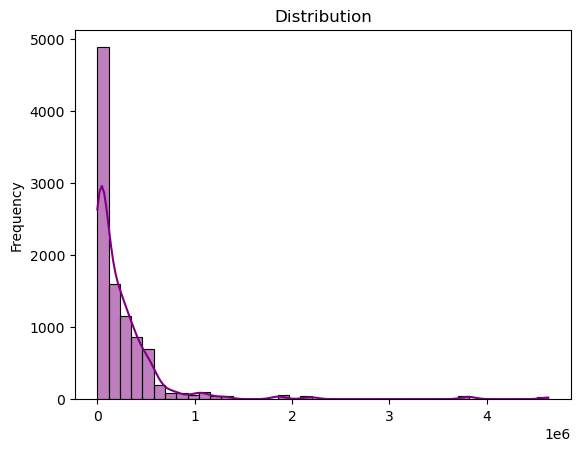

In [21]:
_plot_dist(initial_resources)

In [22]:
initial_states

{'period': array([0, 0, 0, ..., 0, 0, 0], dtype=int16),
 'lagged_choice': Array([0, 0, 8, ..., 4, 0, 8], dtype=int32),
 'married': Array([1, 0, 0, ..., 1, 1, 1], dtype=int32),
 'has_sibling': Array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'mother_age': Array([73, 86, 74, ..., 79, 78, 72], dtype=int32),
 'father_age': Array([76, 73, 78, ..., 96, 69, 78], dtype=int32),
 'mother_alive': Array([1, 1, 0, ..., 1, 1, 1], dtype=int32),
 'father_alive': Array([0, 1, 1, ..., 0, 0, 0], dtype=int32),
 'mother_health': Array([1, 0, 2, ..., 1, 1, 1], dtype=int32),
 'father_health': Array([0, 1, 0, ..., 0, 1, 1], dtype=int32),
 'care_demand': array([0, 0, 0, ..., 0, 0, 0], dtype=int16)}

In [23]:
initial_states["mother_age"].mean(), initial_states["mother_age"].std()

(Array(76.3378, dtype=float32), Array(4.183526, dtype=float32))

In [24]:
initial_states["father_age"].mean(), initial_states["father_age"].std()

(Array(77.4143, dtype=float32), Array(4.114809, dtype=float32))

In [25]:
initial_conditions.loc["mother_age_mean"], initial_conditions.loc["mother_age_std"]

(moment    76.367568
 Name: mother_age_mean, dtype: float64,
 moment    4.199512
 Name: mother_age_std, dtype: float64)

In [26]:
initial_conditions.loc["father_age_mean"], initial_conditions.loc["father_age_std"]

(moment    77.471698
 Name: father_age_mean, dtype: float64,
 moment    4.110863
 Name: father_age_std, dtype: float64)

# 1. Simulation